# Real-NVP

Real-NVP implementation in less than 100 lines of [JAX](https://github.com/google/jax)

Author: Eric Jang

In [3]:
%pip install --upgrade jax jaxlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.3 kB/s eta 0:00:0000:0100:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 MB 733.8 kB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 863.3 kB/s eta 0:00:0000:0100:01
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 993.5 kB/s eta 0:00:00a 0:00:01
  Created wheel for jax: filename=jax-0.4.2-py3-none-any.whl size=1363010 sha256=8e79ef3f10a7bd6ff20167cec422da267c61f4591f1d764e3246442229941614
  Stored in directory: /home/manhph5/.cache/pip/wheels/dc/4f/2b/e0dd187e3644b96d8d54f832ec9f9a4560dfb0a896f55dffe4
Successfully built jax
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling 

In [3]:
import jax.numpy as np
from jax import random

## Data

$p(x)$

(-2.0, 2.0)

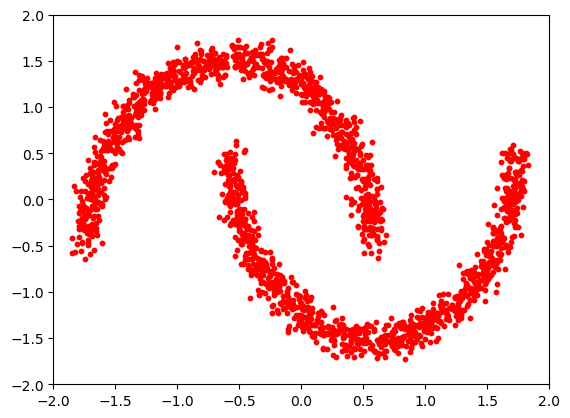

In [4]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

In [5]:
# Initialize parameters, not committing to a batch shape
rng = random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
# N(1, 1)
# X = random.normal(rng, (n_samples, 2)) + 1

## Base Distribution

In [7]:
def sample_n01(N):
  D = 2
  return random.normal(rng, (N, D))

def log_prob_n01(x):
  return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

(array([ 30., 230., 536., 307., 131.,  87.,  96.,  85., 173., 325.]),
 array([-3.7125888, -3.5315459, -3.3505027, -3.1694598, -2.988417 ,
        -2.8073738, -2.6263309, -2.445288 , -2.2642448, -2.083202 ,
        -1.9021589], dtype=float32),
 <BarContainer object of 10 artists>)

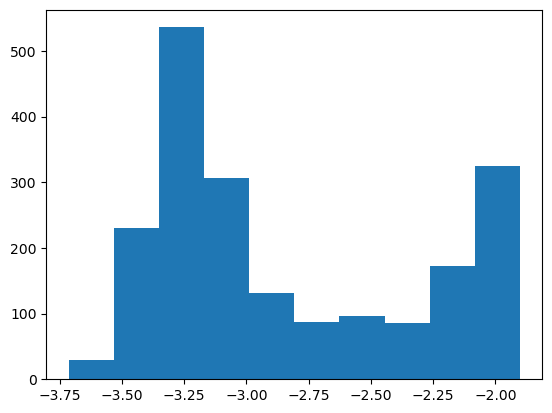

In [8]:
plt.hist(log_prob_n01(X))

## Real-NVP

Affine coupling layer

$x_2=x_1$

$y_2=x_1*e^{s(x_1)}+t(x_1)$

In [9]:
from jax.example_libraries import stax # neural network library
from jax.example_libraries.stax import Dense, Relu # neural network layers 

In [10]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
  d = x.shape[-1]//2
  x1, x2 = x[:, :d], x[:, d:]
  if flip:
    x2, x1 = x1, x2
  shift, log_scale = shift_and_log_scale_fn(net_params, x1)
  y2 = x2*np.exp(log_scale) + shift
  if flip:
    x1, y2 = y2, x1
  y = np.concatenate([x1, y2], axis=-1)
  return y

In [11]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
  d = y.shape[-1]//2
  y1, y2 = y[:, :d], y[:, d:]
  if flip:
    y1, y2 = y2, y1
  shift, log_scale = shift_and_log_scale_fn(net_params, y1)
  x2 = (y2-shift)*np.exp(-log_scale)
  if flip:
    y1, x2 = x2, y1
  x = np.concatenate([y1, x2], axis=-1)
  return x, log_scale


$\log p(x) = \log p(f^{-1}(x)) + |\log det J(f^{-1})(x)| $

In [12]:
def init_nvp():
  D = 2
  net_init, net_apply = stax.serial(
    Dense(512), Relu, Dense(512), Relu, Dense(D))
  in_shape = (-1, D//2)
  out_shape, net_params = net_init(rng, in_shape)
  def shift_and_log_scale_fn(net_params, x1):
    s = net_apply(net_params, x1)
    return np.split(s, 2, axis=1)
  return net_params, shift_and_log_scale_fn

def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
  x = base_sample_fn(N)
  return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
  x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
  ildj = -np.sum(log_scale, axis=-1)
  return base_log_prob_fn(x) + ildj

In [13]:
def init_nvp_chain(n=2):
  flip = False
  ps, configs = [], []
  for i in range(n):
    p, f = init_nvp()
    ps.append(p), configs.append((f, flip))
    flip = not flip
  return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N):
  x = base_sample_fn(N)
  for p, config in zip(ps, configs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  return x

def make_log_prob_fn(p, log_prob_fn, config):
  shift_log_scale_fn, flip = config
  return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
  log_prob_fn = base_log_prob_fn
  for p, config in zip(ps, configs):
    log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
  return log_prob_fn(y)

In [14]:
ps, cs = init_nvp_chain(4)
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

(array([  8.,  47., 123., 455., 513., 145., 115., 110., 185., 299.]),
 array([-4.003489 , -3.800406 , -3.597323 , -3.3942397, -3.1911566,
        -2.9880736, -2.7849903, -2.5819073, -2.3788242, -2.1757412,
        -1.972658 ], dtype=float32),
 <BarContainer object of 10 artists>)

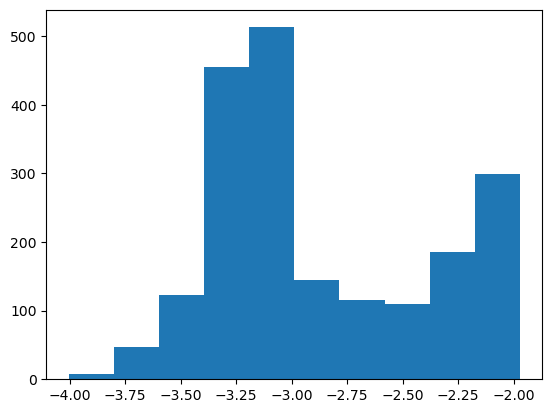

In [15]:
plt.hist(log_prob_nvp_chain(ps, cs, log_prob_n01, X))

## Train It

In [17]:
from jax.example_libraries import optimizers
from jax import jit, grad
import numpy as onp
ps, cs = init_nvp_chain(4)

def loss(params, batch):
  return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
  params = get_params(opt_state)
  g = grad(loss)(params, batch)
  return opt_update(i, g, opt_state)

iters = int(1e4)
data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(ps)
for i in range(iters):
  opt_state = step(i, opt_state, next(data_generator))
ps = get_params(opt_state)

In [18]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

In [19]:
y.max()

Array(3.4378605, dtype=float32)

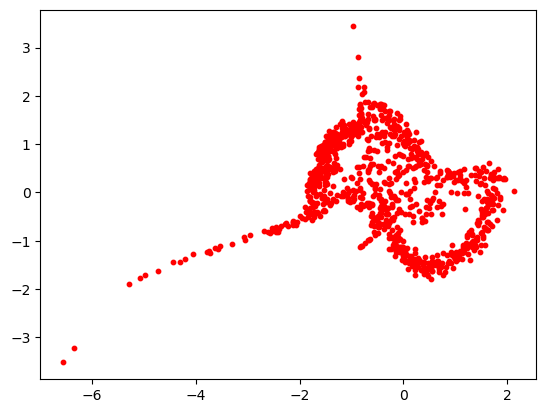

In [20]:
plt.scatter(y[:, 0], y[:, 1], s=10, color='red')
xlim, ylim = [-3, 3], [-3, 3]
# plt.xlim(xlim)
# plt.ylim(ylim)

## Animation

In [21]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [22]:
# !brew install imagemagick

In [23]:
x = sample_n01(1000)
values = [x]
for p, config in zip(ps, cs):
  shift_log_scale_fn, flip = config
  x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
  values.append(x)

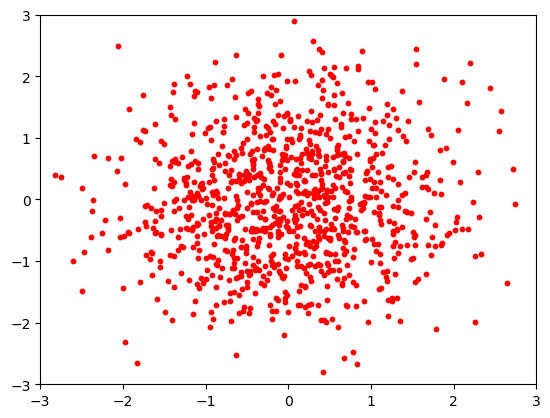

In [24]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

y = values[0]
paths = ax.scatter(y[:, 0], y[:, 1], s=10, color='red')

In [25]:
# Reverse the list to view animation in reverse.
# values = list(reversed(values))

In [26]:
def animate(i):
  l = i//48
  t = (float(i%48))/48
  y = (1-t)*values[l] + t*values[l+1]
  paths.set_offsets(y)
  return (paths,)

In [27]:
anim = animation.FuncAnimation(fig, animate, frames=48*len(cs), interval=1, blit=False)

In [28]:
anim.save('anim2.gif', writer='imagemagick', fps=60)

In [29]:
Image(url='anim2.gif')